In [ ]:
%pip install jax
%pip install flax
%pip install matplotlib

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("cmoyacal/operator-data")

print("Path to dataset files:", path)

100%|██████████| 3.13M/3.13M [00:00<00:00, 74.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/cmoyacal/operator-data/versions/3


In [ ]:
import jax.numpy as jnp
import jax
import os

In [ ]:
train = jnp.load(os.path.join(path, "antiderivative/train_data.npz"))
test = jnp.load(os.path.join(path, "antiderivative/test_data.npz"))
eval = jnp.load(os.path.join(path, "antiderivative/eval_data.npz"))

In [ ]:
train["X_func"].shape, train["X_loc"].shape, train["y"].shape

((1000, 100), (1000, 1), (1000, 1))

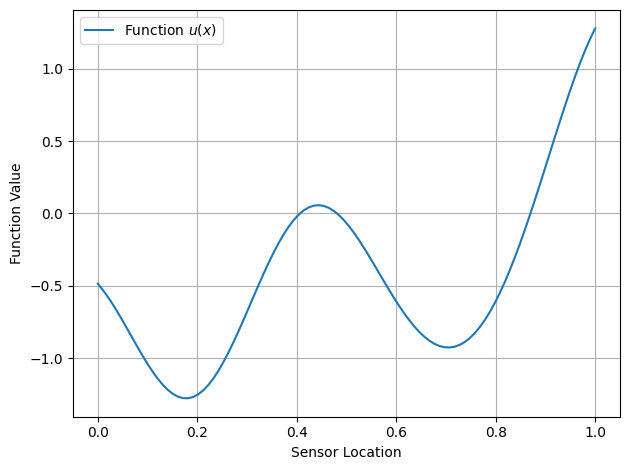

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
sample_idx = 1
func_values = train["X_func"][sample_idx]
location = train["X_loc"][sample_idx]
target_output = train["y"][sample_idx]
sensor_points = np.linspace(0, 1, 100)

plt.plot(sensor_points, func_values, label='Function $u(x)$')
plt.xlabel('Sensor Location')
plt.ylabel('Function Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from flax import nnx
class branch(nnx.Module):
  def __init__(self, *, rngs: nnx.Rngs):
    self.linear1 = nnx.Linear(100, 40, rngs=rngs)
    self.linear2 = nnx.Linear(40, 40, rngs=rngs)

  def __call__(self, x):
    x = nnx.relu(self.linear1(x))
    x = nnx.relu(self.linear2(x))
    return x


In [ ]:
class trunk(nnx.Module):
  def __init__(self, *, rngs: nnx.Rngs):
    self.linear1 = nnx.Linear(1, 40, rngs=rngs)
    self.linear2 = nnx.Linear(40, 40, rngs=rngs)
    self.linear3 = nnx.Linear(40, 40, rngs=rngs)

  def __call__(self, x):
    x = nnx.relu(self.linear1(x))
    x = nnx.relu(self.linear2(x))
    x = nnx.relu(self.linear3(x))
    return x

In [ ]:
class DeepONets(nnx.Module):
    def __init__(self, *, rngs: nnx.Rngs):
        self.branch_net = branch(rngs=rngs)
        self.trunk_net = trunk(rngs=rngs)
        self.bias = nnx.Param(jax.random.normal(rngs.params(), shape=(1,)))  # scalar bias

    def __call__(self, x, y):
        b_out = self.branch_net(x)
        t_out = self.trunk_net(y)
        dot_product = jnp.vdot(b_out, t_out)
        return dot_product + self.bias

model = DeepONets(rngs=nnx.Rngs(0))
nnx.display(model)

In [ ]:
model(train["X_func"][0],train["X_loc"][0])

Array([2.9780073], dtype=float32)

In [ ]:
import optax

learning_rate = 0.001
momentum = 0.9

optimizer = nnx.Optimizer(model, optax.adamw(learning_rate, momentum))
metrics = nnx.MultiMetric(
  accuracy=nnx.metrics.Accuracy(),
  loss=nnx.metrics.Average('loss'),
)

In [ ]:
from functools import partial

def loss_fn(model, u, y, g):
    logit = model(u, y)
    loss = 2 * optax.l2_loss(logit, g)
    return loss, logit

def loss_fn_mean(model,u, y, g):
    loss_fn_partial = partial(loss_fn, model)
    loss_fn_vmap = jax.vmap(loss_fn_partial, in_axes=(0, 0, 0), out_axes=(0, 0))
    losses, logits = loss_fn_vmap(u, y, g)
    return jnp.mean(losses), logits

In [ ]:
loss, logits = loss_fn_mean(model,train["X_func"], train["X_loc"], train["y"])
loss

Array(1.461437, dtype=float32)

In [ ]:
def train_step(model,u, y, g):
    grad_fn = nnx.value_and_grad(loss_fn_mean, has_aux=True)
    (loss, logits), grads = grad_fn(model,u, y, g)
    return grads, loss, logits

In [ ]:
grads, loss, logits=train_step(model,train["X_func"], train["X_loc"], train["y"])

In [ ]:
def test_loss(model,u,y,g):
  test_losses=[]
  for i in range(1):
      u_funcs = u[i]
      x_locs  = y[i]
      y_true  = g[i]
      loss, logits = loss_fn_mean(model,u_funcs , x_locs,y_true)
      test_losses.append(loss)
      mean_loss = np.mean(test_losses)
  return mean_loss

In [ ]:
import matplotlib.pyplot as plt
train_mse=[]
test_mse=[]
for i in range(5000):
  grads,loss,logits=train_step(model,train["X_func"],train["X_loc"], train["y"])
  tloss=test_loss(model,test["X_func"], test["X_loc"], test["y"])
  train_mse.append(loss)
  test_mse.append(tloss)
  optimizer.update(grads=grads)




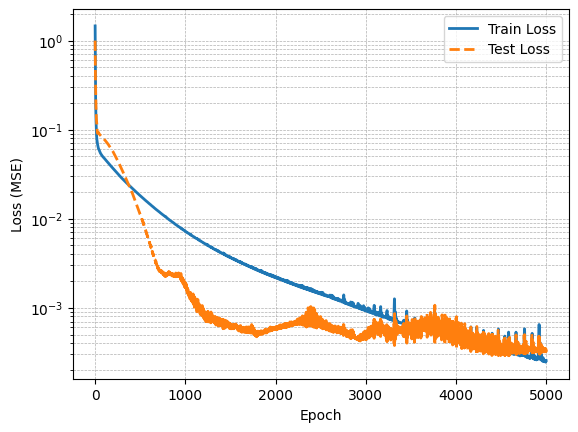

In [ ]:
plt.plot(train_mse, label="Train Loss", linewidth=2)
plt.plot(test_mse, linestyle='--', label="Test Loss", linewidth=2)

plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.yscale("log")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
pi_value = math.pi

def evaluate_and_plot_model(model, loss_fn):

    n = 100
    x_values = np.linspace(0, 1, n)
    f = np.sin(2*pi_value*x_values)

    F = np.zeros_like(f)
    for i in range(1, n):
        F[i] = F[i-1] + 0.5 * (f[i-1] + f[i]) * (x_values[i] - x_values[i-1])


    test_x_func = f
    test_x_loc = x_values
    test_y = np.array([2.18e-3])


    logits = []
    for i in range(n):
        x_input = np.array([test_x_loc[i]])
        loss, logit = loss_fn(model, test_x_func, x_input, test_y)
        logits.append(logit)

    logits = np.array(logits).squeeze()


    plt.plot(x_values, f)
    plt.plot(x_values, F, label='Antiderivative of f(x)', linestyle='--')
    plt.plot(test_x_loc, logits, label='Model logits', linestyle='-.')
    plt.xlabel('x')
    plt.ylabel('Value')
    plt.title('Function, Antiderivative, and Model Logits')
    plt.legend()
    plt.grid(True)
    plt.show()

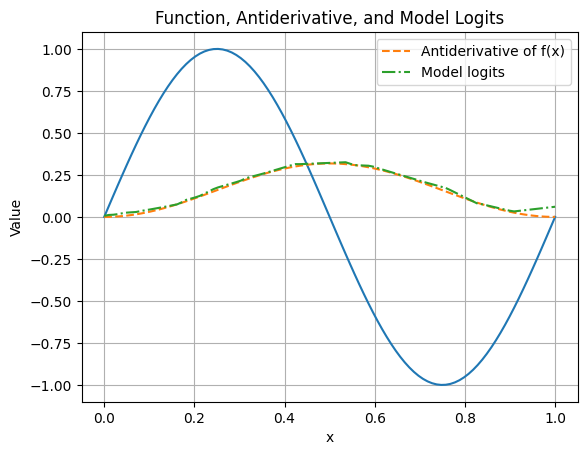

In [ ]:
evaluate_and_plot_model(model, loss_fn)